Load the houseprices data from Thinkful's database.

In [1]:
%reload_ext nb_black
import warnings

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error

import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
from statsmodels.stats.outliers_influence import variance_inflation_factor

import seaborn as sns
import matplotlib.pyplot as plt

from sqlalchemy import create_engine

%matplotlib inline

warnings.filterwarnings("ignore")
postgres_user = "dsbc_student"
postgres_pw = "7*.8G9QH21"
postgres_host = "142.93.121.174"
postgres_port = "5432"
postgres_db = "houseprices"

engine = create_engine(
    "postgresql://{}:{}@{}:{}/{}".format(
        postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db
    )
)
house_df = pd.read_sql_query("select * from houseprices", con=engine)

engine.dispose()

<IPython.core.display.Javascript object>

In [2]:
house_df.shape

(1460, 81)

<IPython.core.display.Javascript object>

Do data cleaning, exploratory data analysis, and feature engineering. You can use your previous work in this module. But make sure that your work is satisfactory.

In [3]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
house_df.head(2)

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,firstflrsf,secondflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,None,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,None,None,None,0,5,2007,WD,Normal,181500


<IPython.core.display.Javascript object>

In [4]:
house_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1460 non-null   int64  
 1   mssubclass     1460 non-null   int64  
 2   mszoning       1460 non-null   object 
 3   lotfrontage    1201 non-null   float64
 4   lotarea        1460 non-null   int64  
 5   street         1460 non-null   object 
 6   alley          91 non-null     object 
 7   lotshape       1460 non-null   object 
 8   landcontour    1460 non-null   object 
 9   utilities      1460 non-null   object 
 10  lotconfig      1460 non-null   object 
 11  landslope      1460 non-null   object 
 12  neighborhood   1460 non-null   object 
 13  condition1     1460 non-null   object 
 14  condition2     1460 non-null   object 
 15  bldgtype       1460 non-null   object 
 16  housestyle     1460 non-null   object 
 17  overallqual    1460 non-null   int64  
 18  overallc

<IPython.core.display.Javascript object>

### Choosing columns to decide sale price

In [5]:
house_df.isna().mean().sort_values(ascending=False)

poolqc           0.995205
miscfeature      0.963014
alley            0.937671
fence            0.807534
fireplacequ      0.472603
lotfrontage      0.177397
garagecond       0.055479
garagetype       0.055479
garageyrblt      0.055479
garagefinish     0.055479
garagequal       0.055479
bsmtexposure     0.026027
bsmtfintype2     0.026027
bsmtfintype1     0.025342
bsmtcond         0.025342
bsmtqual         0.025342
masvnrarea       0.005479
masvnrtype       0.005479
electrical       0.000685
utilities        0.000000
yearremodadd     0.000000
mssubclass       0.000000
foundation       0.000000
extercond        0.000000
exterqual        0.000000
exterior2nd      0.000000
exterior1st      0.000000
roofmatl         0.000000
roofstyle        0.000000
yearbuilt        0.000000
lotconfig        0.000000
overallcond      0.000000
overallqual      0.000000
housestyle       0.000000
bldgtype         0.000000
condition2       0.000000
bsmtfinsf1       0.000000
mszoning         0.000000
lotarea     

<IPython.core.display.Javascript object>

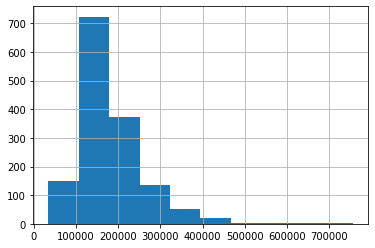

<IPython.core.display.Javascript object>

In [6]:
house_df["saleprice"].hist()

In [7]:
house_df["mszoning"].unique()

array(['RL', 'RM', 'C (all)', 'FV', 'RH'], dtype=object)

<IPython.core.display.Javascript object>

In [8]:
house_df["lotshape"].unique()

array(['Reg', 'IR1', 'IR2', 'IR3'], dtype=object)

<IPython.core.display.Javascript object>

In [9]:
house_df["utilities"].unique()

array(['AllPub', 'NoSeWa'], dtype=object)

<IPython.core.display.Javascript object>

In [10]:
house_df["lotconfig"].unique()

array(['Inside', 'FR2', 'Corner', 'CulDSac', 'FR3'], dtype=object)

<IPython.core.display.Javascript object>

In [11]:
house_df["street"].unique()

array(['Pave', 'Grvl'], dtype=object)

<IPython.core.display.Javascript object>

In [12]:
house_df = house_df[
    [
        "mszoning",
        "lotarea",
        "street",
        "utilities",
        "housestyle",
        "overallqual",
        "roofstyle",
        "totalbsmtsf",
        "grlivarea",
        "kitchenqual",
        "fireplaces",
        "garagearea",
        "yrsold",
        "saleprice",
    ]
]

<IPython.core.display.Javascript object>

In [13]:
house_df.head(2)

,mszoning,lotarea,street,utilities,housestyle,overallqual,roofstyle,totalbsmtsf,grlivarea,kitchenqual,fireplaces,garagearea,yrsold,saleprice
0,RL,8450,Pave,AllPub,2Story,7,Gable,856,1710,Gd,0,548,2008,208500
1,RL,9600,Pave,AllPub,1Story,6,Gable,1262,1262,TA,1,460,2007,181500


<IPython.core.display.Javascript object>

### Getting rid of outlier values

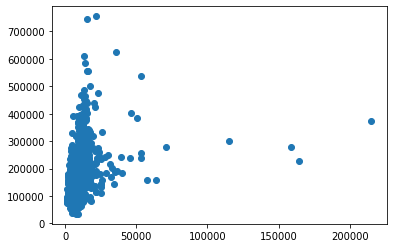

<IPython.core.display.Javascript object>

In [14]:
plt.scatter(house_df["lotarea"], house_df["saleprice"])
plt.show()

In [15]:
house_df = house_df[house_df["lotarea"] < 100000]

<IPython.core.display.Javascript object>

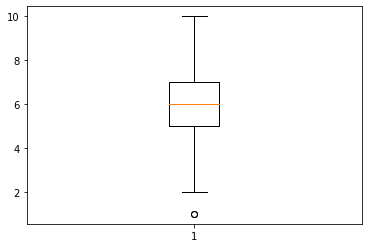

<IPython.core.display.Javascript object>

In [16]:
plt.boxplot(house_df["overallqual"])
plt.show()

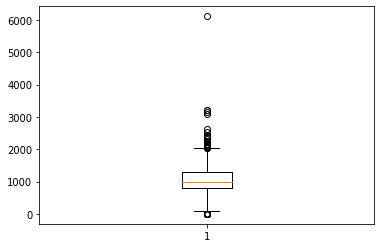

<IPython.core.display.Javascript object>

In [17]:
plt.boxplot(house_df["totalbsmtsf"])
plt.show()

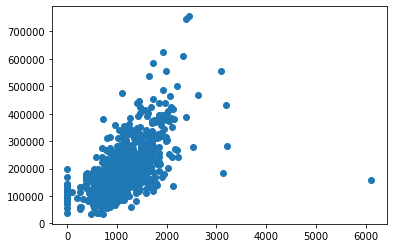

<IPython.core.display.Javascript object>

In [18]:
plt.scatter(house_df["totalbsmtsf"], house_df["saleprice"])
plt.show()

In [19]:
house_df = house_df[house_df["totalbsmtsf"] < 6000]

<IPython.core.display.Javascript object>

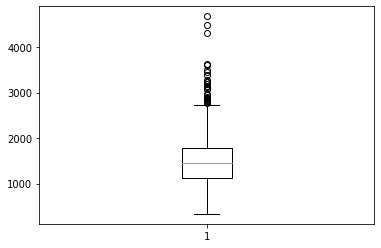

<IPython.core.display.Javascript object>

In [20]:
plt.boxplot(house_df["grlivarea"])
plt.show()

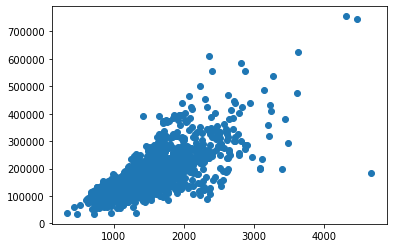

<IPython.core.display.Javascript object>

In [21]:
plt.scatter(house_df["grlivarea"], house_df["saleprice"])
plt.show()

In [22]:
house_df = house_df[house_df["grlivarea"] < 4000]

<IPython.core.display.Javascript object>

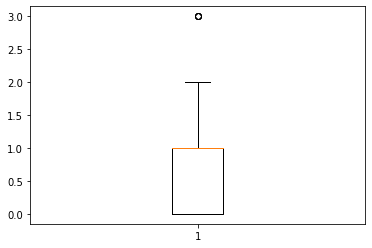

<IPython.core.display.Javascript object>

In [23]:
plt.boxplot(house_df["fireplaces"])
plt.show()

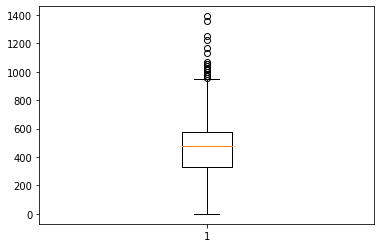

<IPython.core.display.Javascript object>

In [24]:
plt.boxplot(house_df["garagearea"])
plt.show()

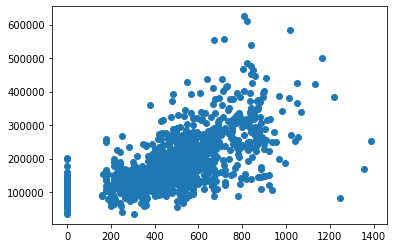

<IPython.core.display.Javascript object>

In [25]:
plt.scatter(house_df["garagearea"], house_df["saleprice"])
plt.show()

In [26]:
house_df = house_df[house_df["garagearea"] < 1200]

<IPython.core.display.Javascript object>

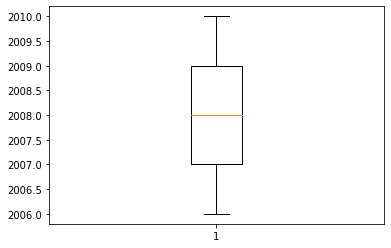

<IPython.core.display.Javascript object>

In [27]:
plt.boxplot(house_df["yrsold"])
plt.show()

### Change all the variables to numeric 

In [28]:
house_df.dtypes

mszoning       object
lotarea         int64
street         object
utilities      object
housestyle     object
overallqual     int64
roofstyle      object
totalbsmtsf     int64
grlivarea       int64
kitchenqual    object
fireplaces      int64
garagearea      int64
yrsold          int64
saleprice       int64
dtype: object

<IPython.core.display.Javascript object>

In [29]:
house_df = pd.concat(
    [house_df, pd.get_dummies(house_df["mszoning"], drop_first=True)], axis=1
)
house_df = pd.concat(
    [house_df, pd.get_dummies(house_df["street"], drop_first=True)], axis=1
)
house_df = pd.concat(
    [house_df, pd.get_dummies(house_df["utilities"], drop_first=True)], axis=1
)
house_df = pd.concat(
    [house_df, pd.get_dummies(house_df["housestyle"], drop_first=True)], axis=1
)
house_df = pd.concat(
    [house_df, pd.get_dummies(house_df["roofstyle"], drop_first=True)], axis=1
)
house_df = pd.concat(
    [house_df, pd.get_dummies(house_df["kitchenqual"], drop_first=True)], axis=1
)
house_df.head(2)


,mszoning,lotarea,street,utilities,housestyle,overallqual,roofstyle,totalbsmtsf,grlivarea,kitchenqual,fireplaces,garagearea,yrsold,saleprice,FV,RH,RL,RM,Pave,NoSeWa,1.5Unf,1Story,2.5Fin,2.5Unf,2Story,SFoyer,SLvl,Gable,Gambrel,Hip,Mansard,Shed,Fa,Gd,TA
0,RL,8450,Pave,AllPub,2Story,7,Gable,856,1710,Gd,0,548,2008,208500,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0
1,RL,9600,Pave,AllPub,1Story,6,Gable,1262,1262,TA,1,460,2007,181500,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1


<IPython.core.display.Javascript object>

In [30]:
house_df = house_df.drop(
    columns=[
        "mszoning",
        "street",
        "utilities",
        "housestyle",
        "roofstyle",
        "kitchenqual",
    ]
)
house_df.head(2)

,lotarea,overallqual,totalbsmtsf,grlivarea,fireplaces,garagearea,yrsold,saleprice,FV,RH,RL,RM,Pave,NoSeWa,1.5Unf,1Story,2.5Fin,2.5Unf,2Story,SFoyer,SLvl,Gable,Gambrel,Hip,Mansard,Shed,Fa,Gd,TA
0,8450,7,856,1710,0,548,2008,208500,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0
1,9600,6,1262,1262,1,460,2007,181500,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1


<IPython.core.display.Javascript object>

In [31]:
house_df.dtypes

lotarea        int64
overallqual    int64
totalbsmtsf    int64
grlivarea      int64
fireplaces     int64
garagearea     int64
yrsold         int64
saleprice      int64
FV             uint8
RH             uint8
RL             uint8
RM             uint8
Pave           uint8
NoSeWa         uint8
1.5Unf         uint8
1Story         uint8
2.5Fin         uint8
2.5Unf         uint8
2Story         uint8
SFoyer         uint8
SLvl           uint8
Gable          uint8
Gambrel        uint8
Hip            uint8
Mansard        uint8
Shed           uint8
Fa             uint8
Gd             uint8
TA             uint8
dtype: object

<IPython.core.display.Javascript object>

### Now, split your data into train and test sets where 20% of the data resides in the test set.

In [32]:
X = house_df.drop(columns=["saleprice"])
y = house_df["saleprice"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

<IPython.core.display.Javascript object>

### Build several linear regression models including Lasso, Ridge, or ElasticNet and train them in the training set. Use k-fold cross-validation to select the best hyperparameters if your models include one!


##### Linear Regression

In [33]:
linear = LinearRegression()
linear.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

<IPython.core.display.Javascript object>

In [34]:
linear.score(X_train, y_train)

0.8563599065930971

<IPython.core.display.Javascript object>

In [35]:
linear.score(X_test, y_test)

0.8264634436973225

<IPython.core.display.Javascript object>

In [36]:
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.848
Method:                 Least Squares   F-statistic:                     289.4
Date:                Wed, 02 Sep 2020   Prob (F-statistic):               0.00
Time:                        14:55:50   Log-Likelihood:                -16956.
No. Observations:                1448   AIC:                         3.397e+04
Df Residuals:                    1419   BIC:                         3.412e+04
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        9.884e+04   1.19e+06      0.083      0.934   -2.23e+06    2.43e+06
lotarea         1.3848      0.175      7.907      0.000       1.041       1.728
overallqual  1.685e+04    984.746     17.114      0.000    1.49e+04    1.88e+04
totalbsmtsf    29.0124      3.165      9.166      0.000      22.803      35.221
grlivarea      46.3007      3.132     14.782      0.000      40.156      52.445
fireplaces   4831.5887   1453.441      3.324      0.001    1980.466    7682.712
garagearea     44.4080      5.053      8.788      0.000      34.496      54.320
yrsold        -85.4392    590.115     -0.145      0.885   -1243.030    1072.151
FV           3.137e+04   1.12e+04      2.812      0.005    9481.733    5.33e+04
RH           1.702e+04   1.28e+04      1.335      0.182   -7997.725     4.2e+04
RL           2.469e+04   1.04e+04      2.370      0.018    4255.911    4.51e+04
RM           1.565e+04   1.05e+04      1.498      0.134   -4847.852    3.62e+04
Pave         2.315e+04   1.53e+04      1.512      0.131   -6879.834    5.32e+04
NoSeWa      -4.429e+04   3.01e+04     -1.473      0.141   -1.03e+05    1.47e+04
1.5Unf       5994.7991   8571.240      0.699      0.484   -1.08e+04    2.28e+04
1Story       8088.7870   3335.215      2.425      0.015    1546.304    1.46e+04
2.5Fin      -2.066e+04   1.14e+04     -1.817      0.069    -4.3e+04    1646.919
2.5Unf      -1.872e+04   9498.825     -1.971      0.049   -3.74e+04     -91.098
2Story       7031.8974   3036.109      2.316      0.021    1076.154     1.3e+04
SFoyer       1.779e+04   5848.519      3.041      0.002    6312.714    2.93e+04
SLvl         9233.9221   4684.992      1.971      0.049      43.669    1.84e+04
Gable        9775.6781   8598.882      1.137      0.256   -7092.208    2.66e+04
Gambrel      1.284e+04   1.25e+04      1.026      0.305   -1.17e+04    3.74e+04
Hip          1.647e+04   8707.617      1.892      0.059    -609.721    3.36e+04
Mansard      3341.4107   1.42e+04      0.236      0.814   -2.45e+04    3.12e+04
Shed         3993.3340   2.27e+04      0.176      0.860   -4.05e+04    4.85e+04
Fa           -5.79e+04   6512.028     -8.892      0.000   -7.07e+04   -4.51e+04
Gd          -4.741e+04   3559.353    -13.321      0.000   -5.44e+04   -4.04e+04
TA          -6.221e+04   4019.091    -15.479      0.000   -7.01e+04   -5.43e+04
==============================================================================
Omnibus:                      367.662   Durbin-Watson:                   2.028
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3225.408
Skew:                           0.925   Prob(JB):                         0.00
Kurtosis:                      10.074   Cond. No.                     1.76e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the co

<IPython.core.display.Javascript object>

##### Ridge Regression

In [37]:
alphas = [np.power(10.0, p) for p in np.arange(-10, 40, 1)]

<IPython.core.display.Javascript object>

In [38]:
ridge_cv = RidgeCV(alphas=alphas, cv=5)

ridge_cv.fit(X_train, y_train)
y_preds_train = ridge_cv.predict(X_train)
y_preds_test = ridge_cv.predict(X_test)

print("Best alpha value is: {}".format(ridge_cv.alpha_))
print(
    "R-squared of the model in training set is: {}".format(
        ridge_cv.score(X_train, y_train)
    )
)
print("-----Test set statistics-----")
print(
    "R-squared of the model in test set is: {}".format(ridge_cv.score(X_test, y_test))
)
print(
    "Mean absolute error of the prediction is: {}".format(
        mean_absolute_error(y_test, y_preds_test)
    )
)
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print(
    "Root mean squared error of the prediction is: {}".format(
        rmse(y_test, y_preds_test)
    )
)
print(
    "Mean absolute percentage error of the prediction is: {}".format(
        np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100
    )
)

Best alpha value is: 1.0
R-squared of the model in training set is: 0.856099381807067
-----Test set statistics-----
R-squared of the model in test set is: 0.8269284029265348
Mean absolute error of the prediction is: 22489.651378687136
Mean squared error of the prediction is: 1002205363.0327464
Root mean squared error of the prediction is: 31657.627248938705
Mean absolute percentage error of the prediction is: 13.530155623147255


<IPython.core.display.Javascript object>

##### Lasso Regression

In [39]:
lasso_cv = LassoCV(alphas=alphas, cv=5)

lasso_cv.fit(X_train, y_train)
y_preds_train = lasso_cv.predict(X_train)
y_preds_test = lasso_cv.predict(X_test)

print("Best alpha value is: {}".format(lasso_cv.alpha_))
print(
    "R-squared of the model in training set is: {}".format(
        lasso_cv.score(X_train, y_train)
    )
)
print("-----Test set statistics-----")
print(
    "R-squared of the model in test set is: {}".format(lasso_cv.score(X_test, y_test))
)
print(
    "Mean absolute error of the prediction is: {}".format(
        mean_absolute_error(y_test, y_preds_test)
    )
)
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print(
    "Root mean squared error of the prediction is: {}".format(
        rmse(y_test, y_preds_test)
    )
)
print(
    "Mean absolute percentage error of the prediction is: {}".format(
        np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100
    )
)

Best alpha value is: 10.0
R-squared of the model in training set is: 0.8562215636780538
-----Test set statistics-----
R-squared of the model in test set is: 0.8267368794818482
Mean absolute error of the prediction is: 22488.833765778058
Mean squared error of the prediction is: 1003314417.4741291
Root mean squared error of the prediction is: 31675.13879171059
Mean absolute percentage error of the prediction is: 13.532507258777915


<IPython.core.display.Javascript object>

###### ElasticNet Regression

In [40]:
elasticnet_cv = ElasticNetCV(alphas=alphas, cv=5)

elasticnet_cv.fit(X_train, y_train)
y_preds_train = elasticnet_cv.predict(X_train)
y_preds_test = elasticnet_cv.predict(X_test)

print("Best alpha value is: {}".format(elasticnet_cv.alpha_))
print(
    "R-squared of the model in training set is: {}".format(
        elasticnet_cv.score(X_train, y_train)
    )
)
print("-----Test set statistics-----")
print(
    "R-squared of the model in test set is: {}".format(
        elasticnet_cv.score(X_test, y_test)
    )
)
print(
    "Mean absolute error of the prediction is: {}".format(
        mean_absolute_error(y_test, y_preds_test)
    )
)
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print(
    "Root mean squared error of the prediction is: {}".format(
        rmse(y_test, y_preds_test)
    )
)
print(
    "Mean absolute percentage error of the prediction is: {}".format(
        np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100
    )
)

Best alpha value is: 0.001
R-squared of the model in training set is: 0.856243864526902
-----Test set statistics-----
R-squared of the model in test set is: 0.8268430227503498
Mean absolute error of the prediction is: 22470.708206004816
Mean squared error of the prediction is: 1002699773.8541416
Root mean squared error of the prediction is: 31665.43500181454
Mean absolute percentage error of the prediction is: 13.487724280151259


<IPython.core.display.Javascript object>

### Evaluate your best model on the test set.


It appears that the Lasso Regression model not only gives the highest R-squared value for the test set, but also provides the lowest value for MAE. Therefore, the Lasso Regression model is the best model for the test set. 

The housing prices can be heavily affected by outside factors. For example, if the economy is not doing well the house pricing would be affected immensely. Adding external variables into them model makes the model more applicable to real world situations and eliminates any biases or ideas that the model is suited just for the specific data frame. 